# Почему пользователи уходят со степика и не заканчивают курс ?

In [357]:
import numpy as np
import pandas as pd

In [358]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [359]:
#так называемые "сырые данные", pandas может вытаскивать данные и с zip формата в т.ч.
#events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression ='zip') 
events_data = pd.read_csv("event_data_train.csv")

In [360]:
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [361]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [362]:
#конвертируем из unix-time в "человеческое"
events_data["date"] = pd.to_datetime(events_data.timestamp, unit = "s")
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [363]:
#с какого момента начинается наш датасет
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [364]:
events_data['day'] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


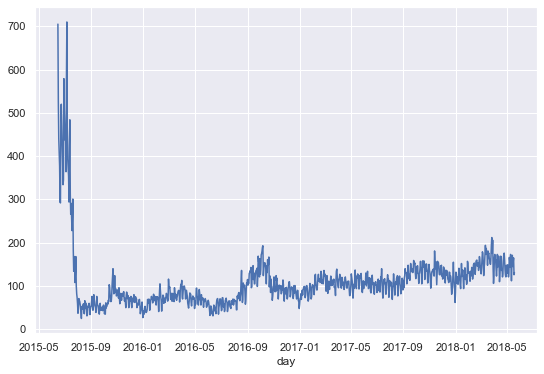

In [365]:
sns.set(rc = {"figure.figsize": (9,6)}) 
events_data.groupby("day") \
        .user_id.nunique().plot()


# Неправильный вариант

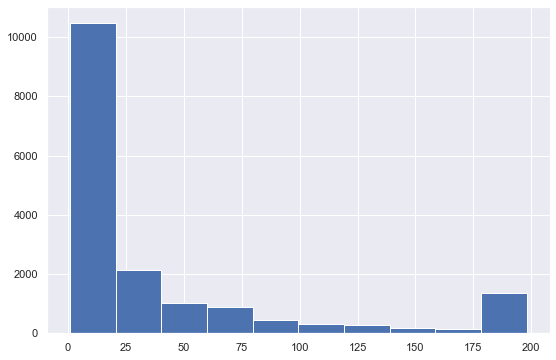

In [366]:
events_data[events_data.action == "passed"] \
        .groupby("user_id", as_index = False) \
        .agg({"step_id" : "count"}) \
        .rename(columns={"step_id" : "passed_steps"}) \
        .passed_steps.hist()
#но такой подход не учитывает пользователей, у которых не пройдено ни одного степа (passed = 0)

# Правильный вариант

In [367]:
events_data.pivot_table(index = "user_id", 
                        columns = "action", 
                        values = "step_id", 
                        aggfunc = "count", 
                        fill_value = 0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


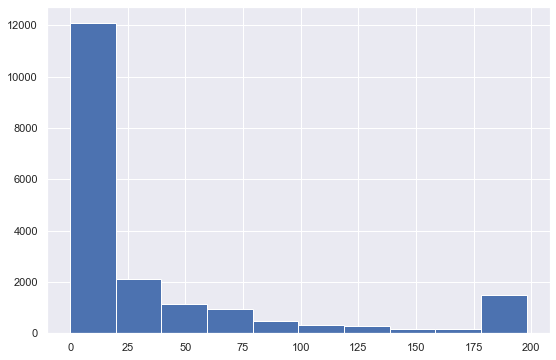

In [368]:
events_data.pivot_table(index = "user_id", 
                        columns = "action", 
                        values = "step_id", 
                        aggfunc = "count", 
                        fill_value = 0).reset_index().discovered.hist()

# dataset submission

In [369]:
submissions_data = pd.read_csv("submissions_data_train.csv")
submissions_data["date"] = pd.to_datetime(submissions_data.timestamp, unit = "s")
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [370]:
users_score = submissions_data.pivot_table(index = "user_id", 
                        columns = "submission_status", 
                        values = "step_id", 
                        aggfunc = "count", 
                        fill_value = 0).reset_index()
users_score.head()


submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [371]:
#ищем степ, который чаще всего был решен неправильно (дали подсказку, что из-за него и уходили чаще всего)
ff = submissions_data.query("submission_status == 'wrong'").groupby("step_id").agg({"user_id" :"count"})
ff.sort_values("user_id")

,user_id
step_id,
32929,85
32175,342
33362,673
33681,703
33482,707
...,...
32075,10003
33481,10300
32202,13002


In [372]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

# Возвращаемся к датасету events

In [373]:
#через apply(list) мы помещаем все временные отметки каждого пользователя (user_id) в список
#через apply(np.diff) ищем разность между двумя ближайшими наблюдениями
events_data[["user_id", "day", "timestamp"]].drop_duplicates(subset = ["user_id", "day"]) \
    .groupby("user_id")["timestamp"].apply(list) \
    .apply(np.diff)

user_id
1                                                       []
2                                                [4843602]
3         [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                               [33702812]
7                                                       []
                               ...                        
26790                           [238225, 893964, 64879648]
26793                                                   []
26794    [86128, 136759, 94899, 1422583, 14347289, 5050...
26797                                            [1567990]
26798                                                   []
Name: timestamp, Length: 19234, dtype: object

In [374]:
gap_data = events_data[["user_id", "day", "timestamp"]].drop_duplicates(subset = ["user_id", "day"]) \
    .groupby("user_id")["timestamp"].apply(list) \
    .apply(np.diff).values

In [375]:
gap_data = pd.Series(np.concatenate(gap_data, axis = 0))
gap_data

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int32

In [376]:
#чтобы вывести разницу в ДНЯХ между двумя ближайшими заходами на курс
gap_data = gap_data / (24 * 60 * 60)

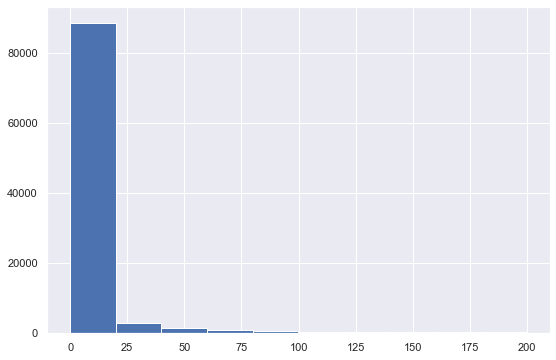

In [377]:
gap_data[gap_data < 200].hist()

In [378]:
#только 5% пользователей возвращаются на курс после 2 месяцев
gap_data.quantile(0.95)

59.760440972222156

In [379]:
#вычислить создателя курса
users_score.sort_values('correct')

submission_status,user_id,correct,wrong
8457,22862,0,5
4566,12222,0,1
364,871,0,1
8165,22080,0,2
9434,25472,0,1
...,...,...,...
3208,8461,135,42
2344,6183,142,65
6415,17135,168,177
2099,5552,186,93


In [380]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [381]:
#максимальное время между степами для каждого юзера
users_data = events_data.groupby("user_id", as_index = False) \
    .agg({"timestamp" : "max"}).rename(columns = {"timestamp" : "last_timestamp"})
users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [382]:
now = 1526772811
#примерная оценка между 95 и 90 перцентилями - 30 дней, переведенная в юникс время:
drop_out_threshold = 2592000

In [383]:
#cколько времени прошло с момента посещения последнего пользователя до текущего таймстемпа
#то есть, последняя колонка показывает, можно ли считать пользователя ушедшим с курса, если он не появлялся больше месяца
users_data["is_gone_user"] = (now - users_data.last_timestamp) > drop_out_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


# Merge

In [384]:
users_score.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [385]:
#важно следить за outer и inner методами
users_data = users_data.merge(users_score, how = "outer")

In [386]:
users_data = users_data.fillna(0)
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [387]:
users_events_data = events_data.pivot_table(index = "user_id", 
                        columns = "action", 
                        values = "step_id", 
                        aggfunc = "count", 
                        fill_value = 0).reset_index()

users_data = users_data.merge(users_events_data, how = "outer")
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [388]:
#добавим число уникальных дней юзера в степике
users_days = events_data.groupby("user_id").day.nunique().to_frame().reset_index()
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [389]:
users_data = users_data.merge(users_days, how = "outer")
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


# Сверим число юзеров в сырых данных и в итоговой табличке

In [390]:
users_data.user_id.nunique()

19234

In [391]:
events_data.user_id.nunique()

19234

In [392]:
users_data['passed_course'] = users_data.passed > 170
users_data.groupby("passed_course").count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


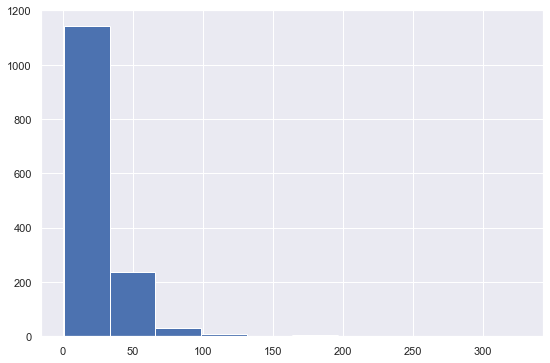

In [393]:
users_data[users_data.passed_course].day.hist()
#медиана = 20 дней т.е. медианно люди проходят курс за 20 дней

In [434]:
#первое активное действие на курсе
user_min_time = events_data.groupby("user_id", as_index = False).agg({"timestamp" : "min"}).rename({"timestamp" : "min_timestamp"}, axis = 1)
user_min_time

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


In [435]:
#сшили id_user и timestamp
events_data["user_time"] = events_data.user_id.map(str) + "_" + events_data.timestamp.map(str)
events_data

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


In [436]:
#создаем трехдневной порог (для попытки предсказать вероятность, что пользователь пройдет курс, если он выполнил)
#второе действие не позже чем через три дня
learning_time_threshold = 3 * 24 * 60 * 60

In [437]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [438]:
user_learning_time_threshold = user_min_time.user_id.map(str) + "_" + (user_min_time.min_timestamp + learning_time_threshold).map(str)
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [439]:
user_min_time["user_learning_time_threshold"] = user_learning_time_threshold


In [440]:
events_data = events_data.merge(user_min_time[["user_id", "user_learning_time_threshold"]], how = "outer")
events_data.shape

(3480703, 8)

In [441]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [442]:
#создаем датафрейм с отобранными признаками у пользователей для обучения
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]
events_data_train

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


In [443]:
#проверка на число дней 
events_data_train.groupby("user_id").day.nunique().max()

4

In [444]:
X = submissions_data_train.groupby("user_id").day.nunique().to_frame().reset_index().rename(columns = {"day" : "days"})
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [445]:
steps_tried = submissions_data_train.groupby("user_id").day.nunique().to_frame().reset_index()\
    .rename(columns = {"step_id" : "steps_tried"})
X = X.merge(steps_tried, on = "user_id", how = "outer")
X.head()

,user_id,days,day
0,2,1,1
1,3,1,1
2,8,1,1
3,14,1,1
4,16,3,3


In [446]:
X.shape

(8913, 3)

In [447]:
X = X.merge(submissions_data_train.pivot_table(index = "user_id", 
                        columns = "submission_status", 
                        values = "step_id", 
                        aggfunc = "count", 
                        fill_value = 0).reset_index())

In [448]:
X["correct_ratio"] =  X.correct / (X.correct + X.wrong)

In [449]:
X = X.merge(events_data_train.pivot_table(index = "user_id", 
                        columns = "action", 
                        values = "step_id", 
                        aggfunc = "count", 
                        fill_value = 0).reset_index()[["user_id", "viewed"]], how = "outer")
X = X.fillna(0)

In [450]:
X = X.merge(users_data[["user_id","passed_course", "is_gone_user"]], how = "outer")

In [451]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]
X.head()

,user_id,days,day,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,1.0,2.0,0.0,1.00,9,False,True
1,3,1.0,1.0,4.0,4.0,0.50,20,False,True
2,8,1.0,1.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,3.0,23.0,27.0,0.46,132,True,True


In [452]:
#для всех юзеров которые не прошли курс - отмечены как дропнутые
X.groupby(["passed_course", "is_gone_user"]).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [453]:
y = X.passed_course.map(int)
X = X.drop(["passed_course", "is_gone_user"], axis = 1)
X

,user_id,days,day,correct,wrong,correct_ratio,viewed
0,2,1.0,1.0,2.0,0.0,1.00,9
1,3,1.0,1.0,4.0,4.0,0.50,20
2,8,1.0,1.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,3.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1
19230,26781,0.0,0.0,0.0,0.0,0.00,6
19231,26788,0.0,0.0,0.0,0.0,0.00,1
19232,26789,0.0,0.0,0.0,0.0,0.00,2


In [454]:
X = X.set_index(X.user_id)
X.head()

,user_id,days,day,correct,wrong,correct_ratio,viewed
user_id,,,,,,,
2,2,1.0,1.0,2.0,0.0,1.00,9
3,3,1.0,1.0,4.0,4.0,0.50,20
8,8,1.0,1.0,9.0,21.0,0.30,154
14,14,1.0,1.0,0.0,1.0,0.00,9
16,16,3.0,3.0,23.0,27.0,0.46,132


In [455]:
X = X.drop("user_id", axis = 1)
X

,days,day,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,1.0,2.0,0.0,1.00,9
3,1.0,1.0,4.0,4.0,0.50,20
8,1.0,1.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,3.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1
26781,0.0,0.0,0.0,0.0,0.00,6
26788,0.0,0.0,0.0,0.0,0.00,1
